# phase_diagram_disorder_analysis

> Create a phase diagram of extension vs disorder and initial tension anisotropy, using hard-disk Monte Carlo to create initial conditions with arbitrary amounts of disorder

This notebook will analyse the result of the phase diagram simulations

In [ ]:
#| default_exp phase_analysis

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

In [ ]:
#| export

import jax
import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.config import config

jax.default_device(jax.devices('cpu')[0])
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)
config.update("jax_platform_name", "cpu")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
#| export

import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso
import CE_simulation.drosophila as drs
import CE_simulation.disorder as dis
import CE_simulation.hessian as hes
import CE_simulation.ecmc as ecm

In [ ]:
#| export

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection

from tqdm.notebook import tqdm

from scipy import spatial, ndimage
from skimage.transform import downscale_local_mean

from collections import Counter
import itertools

from copy import deepcopy
import os
import pickle

In [ ]:
#| export

from joblib import Parallel, delayed
import gc

In [ ]:
#| export

from typing import Sequence, Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
## reloading the modules in case you edit them

import importlib

importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso);
importlib.reload(drs); importlib.reload(dis); importlib.reload(ecm);

### Define analysis & plotting functions

In [ ]:
#| export

def get_width_height(mesh, q=0.8, exclude=None):
    """Get tissue extension by means of q% x- and y-axis bounding box"""
    exclude = [] if exclude is None else exclude
    centroids = np.stack([v.get_centroid() for key, v in mesh.vertices.items()
                           if (not v.is_bdry()) and (not v._vid in exclude)])

    delta = np.quantile(centroids, axis=0, q=q)-np.quantile(centroids, axis=0, q=1-q,)
    return delta


def get_delta_centerline(meshes, sigma=2, add_start_pt=True):
    """Get tissue extension using the centerline measure."""
    start, stop = ecm.get_left_right_pt(meshes[0])
    top_bdry, bottom_bdry = ecm.get_top_bottom_bdry(meshes[0], tol=4)

    
    centerlines = []
    lengths = []
    widths = []

    for m in tqdm(meshes):
        centerlines.append(ecm.get_centerline(m, start, stop, dx=0.5, sigma=2))
        lengths.append(ecm.get_arclen(centerlines[-1]))
        widths.append(ecm.get_width(m, top_bdry, bottom_bdry))

    delta = np.log(np.stack([np.array(lengths)/lengths[0], np.array(widths)/widths[0]], axis=-1))
    if add_start_pt:
        delta = np.vstack([[0,0], delta])
    if sigma > 0:
        delta_smooth = ndimage.gaussian_filter1d(delta, sigma, axis=0)
    return delta_smooth, centerlines

In [ ]:
#| export

def get_anisos_S(mesh):
    """Compute single-triangle and mean anisotropy based on the quadratic S=T.T tensor"""
    tensors = np.stack([fc.get_stress_tensor() for fc in mesh.faces.values()])
    tensors = (tensors.T / np.linalg.eigvalsh(tensors).sum(axis=1)).T # normalize

    vals_all = np.linalg.eigvalsh(tensors)
    anisotropy_all = np.mean(vals_all[:,1] - vals_all[:,0])

    vals_mean = np.linalg.eigvalsh(tensors.mean(axis=0))
    anisotropy_mean = vals_mean[1] - vals_mean[0]

    return anisotropy_mean, anisotropy_all
def get_anisos_T(mesh):
    """Compute single-triangle and mean anisotropy based on the singular values of the linear T tensor"""
    T_tensors = np.stack([val for val in mesh.get_T_tensor().values()])
    U, S, Vh = np.linalg.svd(T_tensors) # we want Vh I think

    S = (2*S.T / S.sum(axis=1)).T # normalize S
    anisotropy_all = np.mean(S[:,1] - S[:,0])
    
    S_diag = np.einsum('ij,nj->nij', np.eye(2), S)
    aniso_tensors = np.einsum('nji,njk,nkl->nil', Vh, S_diag, Vh)
    anisotropy_mean = np.linalg.eigvalsh(aniso_tensors.mean(axis=0))
    anisotropy_mean = anisotropy_mean[1] - anisotropy_mean[0]
    
    return anisotropy_all, anisotropy_mean

In [ ]:
#| export

def get_excess_aniso(mesh):
    """Compute 'excess' single triangle anisotropy"""
    tensors = np.stack([fc.get_stress_tensor() for fc in mesh.faces.values()])
    tensors = (tensors.T / np.linalg.eigvalsh(tensors).sum(axis=1)).T # normalize

    # subtract trace
    tensors = tensors-np.einsum('vii,jk->vjk', tensors, np.eye(2))/2
    tensors_mean = tensors.mean(axis=0)
    
    tensors_nomean = tensors - tensors_mean
    tensors_norm = (2*np.linalg.norm(tensors, axis=(1,2), ord=2)**2).mean()
    tensors_mean_norm = (2*np.linalg.norm(tensors_mean, axis=(0,1), ord=2)**2)
    tensors_nomean_norm = (2*np.linalg.norm(tensors_nomean, axis=(1,2), ord=2)**2).mean()
    
    return np.sqrt(tensors_norm), np.sqrt(tensors_mean_norm), np.sqrt(tensors_nomean_norm)

In [ ]:
#| export

def make_segments3d(x, y, z):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """
    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


def colorline3d(x, y, z, cmap='cool', norm=plt.Normalize(0.0, 1.0),
              linewidth=3, alpha=1.0, ax=None):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    segments = make_segments3d(x, y, z)
    arr = np.linspace(0.0, 1.0, len(x))

    # Default colors equally spaced on [0,1]:
    lc = Line3DCollection(segments, cmap=cmap, norm=norm, array=arr,
                          linewidth=linewidth, alpha=alpha)
    if ax is None:
        ax = plt.gca()
    ax.add_collection3d(lc)
        
    return lc

In [ ]:
plot_dir = "/home/fbrauns/Nikolas/code/CE_simulation/plots/v2"

## Mesh plots

In [ ]:
#base_dir = "/data/Nikolas/GBE_simulation/runs/hard_disks/small size runs/area_phase_diag_small"
#base_dir = "/data/Nikolas/GBE_simulation/runs/hard_disks/small size runs/perimeter_phase_diag_small_new_post_T1_try_again"
base_dir = "/data/Nikolas/GBE_simulation/runs/hard_disks/perimeter_phase_diag_new_post_T1_once_more"

In [ ]:
## load example meshes for plots

n_steps = 500 # 699
step = 1 # 10

strain = 0.2 #0.1180339887498949 
eta = 0.9
random_seed = 3 # 2 best so far

sim_dir = f"{base_dir}/eta_{eta}_anisotropy_{strain}_randomSeed_{random_seed}"

meshes_ordered = [iso.CellHalfEdgeMesh.load_mesh(f'{sim_dir}/{str(i).zfill(4)}_mesh')
                  for i in tqdm(range(1, n_steps, step))]
with open(f"{sim_dir}/property_dict.pickle", "rb") as f:
    property_dict_ordered = pickle.load(f)
    
# make "rounded" edges ??

  0%|          | 0/499 [00:00<?, ?it/s]

In [ ]:
eta = 0.45
random_seed = 3 # 3 best so far

sim_dir = f"{base_dir}/eta_{eta}_anisotropy_{strain}_randomSeed_{random_seed}"
meshes_disordered = [iso.CellHalfEdgeMesh.load_mesh(f'{sim_dir}/{str(i).zfill(4)}_mesh')
                  for i in tqdm(range(1, n_steps, step))]
with open(f"{sim_dir}/property_dict.pickle", "rb") as f:
    property_dict_disordered = pickle.load(f)

  0%|          | 0/499 [00:00<?, ?it/s]

In [ ]:
edge_colors_ordered_tri = {key: np.array([0.8, 0.2, 0, .2]) if 
                           any([v.is_bdry() for v in he.vertices]) else np.array([0.8, 0.2, 0, 1])
                           for key, he in meshes_ordered[0].hes.items()}
cell_colors_ordered = {key: "#eebbaaff" for key, val in meshes_ordered[0].vertices.items() if not val.is_bdry()}

edge_colors_disordered_tri = {key: np.array([0.8, 0.2, 0, .2]) if 
                              any([v.is_bdry() for v in he.vertices]) else np.array([0.8, 0.2, 0, 1])
                           for key, he in meshes_disordered[0].hes.items()}
cell_colors_disordered = {key: "#eebbaaff" for key, val in meshes_disordered[0].vertices.items()
                          if not val.is_bdry()}

In [ ]:
norm = mpl.colors.Normalize(vmin=4, vmax=8)

def valence_to_colormap(val):
    return np.array(mpl.cm.PiYG(norm(val), bytes=True))/255 #PiYG, PRGn, bwr

In [ ]:
def plot_patches(i):
    fig, ((ax1, ax2), (ax1b, ax2b)) = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
    #, facecolor="white", dpi=300,)
    bdry_x, bdry_y = (26, 16)
    
    [ax.cla() for ax in [ax1, ax2, ax1b, ax2b]]
    
    # define cell colors based on coordination number
    cell_colors_ordered = {key: valence_to_colormap(len(v.faces)) for key, v in meshes_ordered[i].vertices.items() if not v.is_bdry()}
    cell_colors_disordered = {key: valence_to_colormap(len(v.faces)) for key, v in meshes_disordered[i].vertices.items() if not v.is_bdry()}

    
    meshes_ordered[i].cellplot(ax=ax1, cell_colors=cell_colors_ordered)
    meshes_ordered[i].triplot_color(ax=ax1b, edge_colors=edge_colors_ordered_tri)

    meshes_disordered[i].cellplot(ax=ax2, cell_colors=cell_colors_disordered)
    meshes_disordered[i].triplot_color(ax=ax2b, edge_colors=edge_colors_disordered_tri)

    #ax1.set_title("Ordered initial cond.", fontsize=16, y=1.05, ha="center")
    #ax2.set_title("Disordered initial cond.", fontsize=16, y=1.05, ha="center")
    ax1b.text(.85, -.1, f"Time: {np.round(i*0.005*25).astype(int)} min", fontsize=16, ha="left", transform=ax1b.transAxes)

    for ax in [ax1, ax2, ax1b, ax2b]:
        ax.set_xlim([-bdry_x, bdry_x])
        ax.set_ylim([-bdry_y, bdry_y])
        ax.set_aspect("equal", adjustable="box")
        ax.axis("off")
    #plt.tight_layout()
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-.125, hspace=0)
    plt.margins(0,0)

In [ ]:
## make a movie

  0%|          | 0/500 [00:00<?, ?it/s]

IndexError: list index out of range

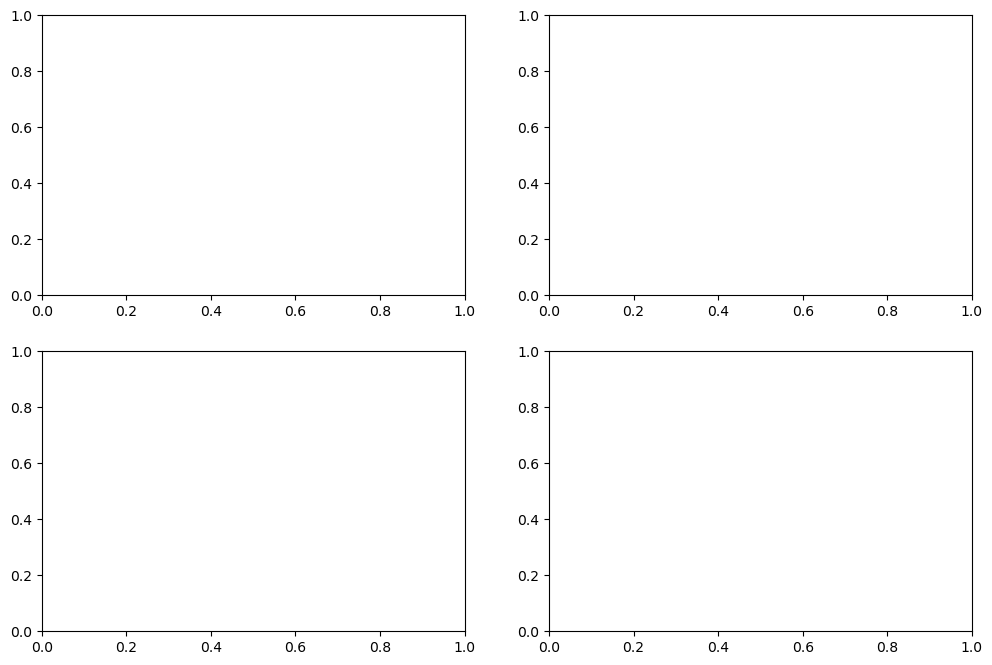

In [ ]:
for i in tqdm(range(1, 501)):
    plot_patches(i)
    plt.savefig(f"{plot_dir}/fig_2_tissue_scale_sim/movie_frames/{str(i).zfill(3)}.png", dpi=150, bbox_inches="tight")
    plt.close()

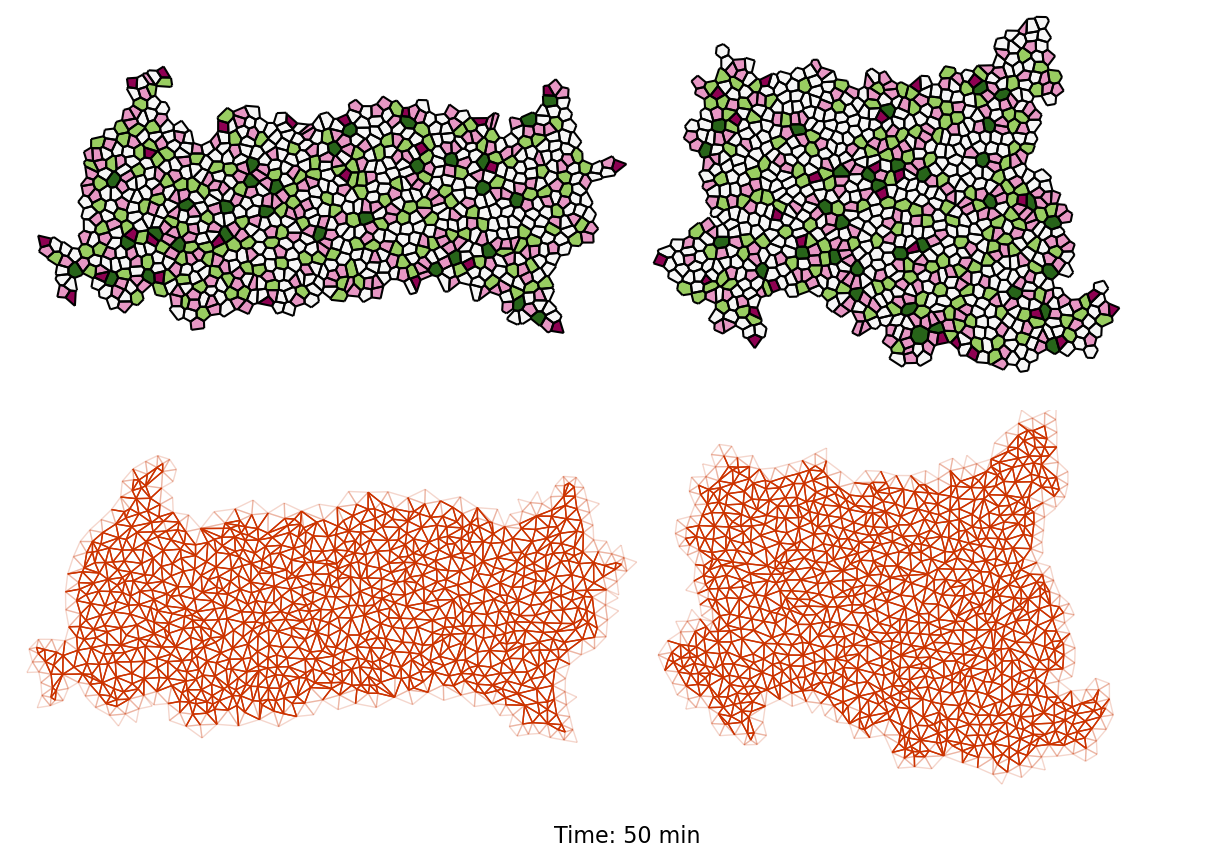

In [ ]:
plot_patches(400)

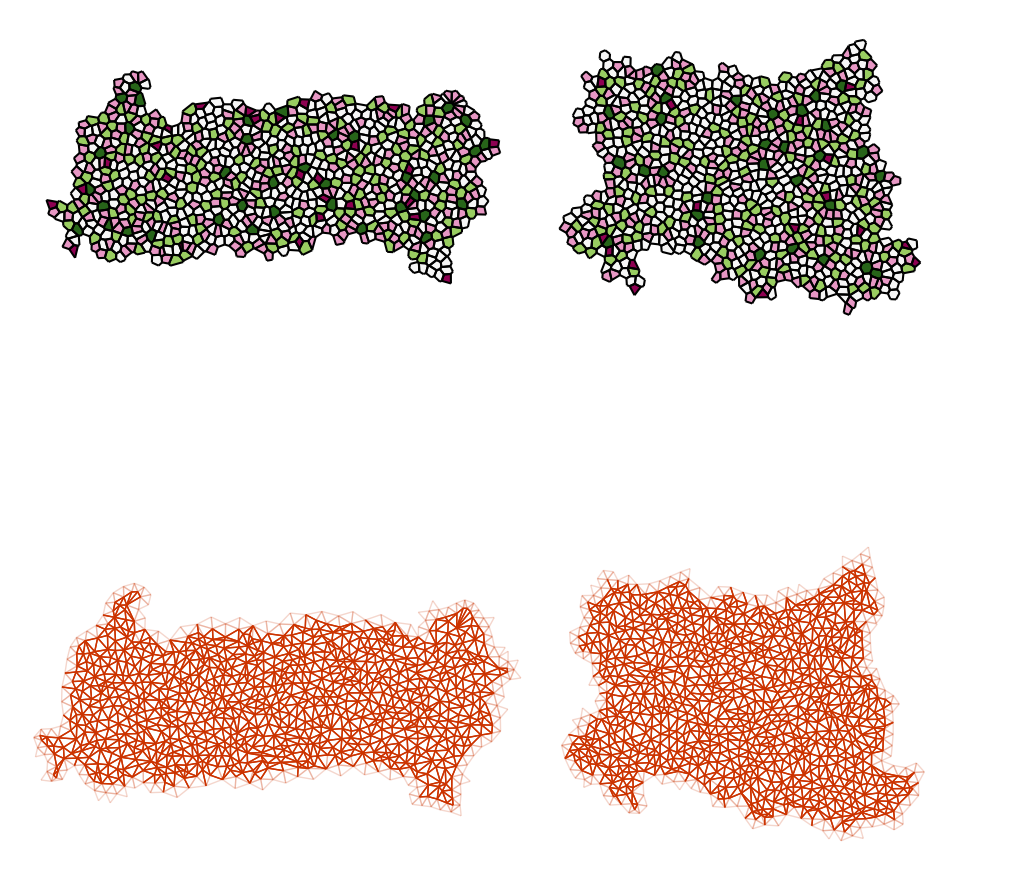

In [ ]:
plot_patches(32) #seed 4 looks best so far for ordered
plt.savefig(f"{plot_dir}/fig_2_tissue_scale_sim/order_vs_disorder_meshes_final.pdf")

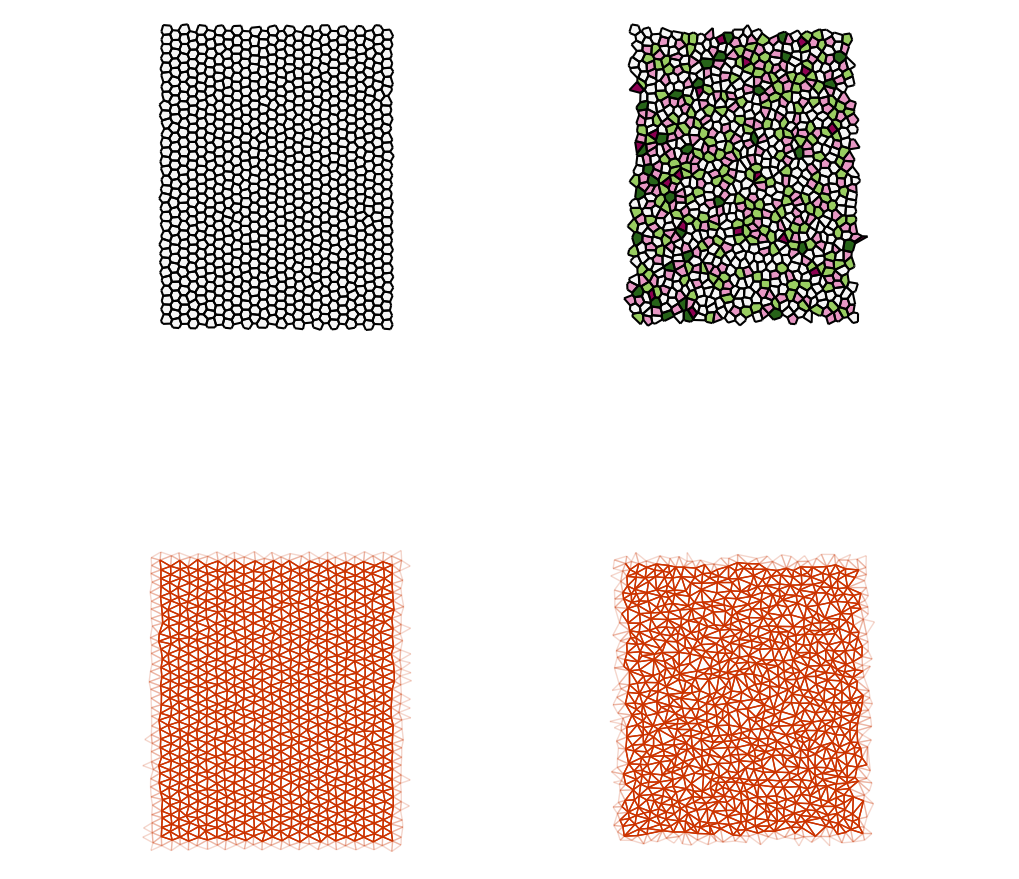

In [ ]:
plot_patches(0)

plt.savefig(f"{plot_dir}/fig_2_tissue_scale_sim/order_vs_disorder_meshes_initial.pdf")

/tmp/ipykernel_3804605/3069966813.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


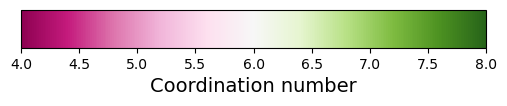

In [ ]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.PiYG
norm = mpl.colors.Normalize(vmin=4, vmax=8)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Coordination number', fontsize=14)
#plt.savefig(f"{plot_dir}/fig_3_phase_diagram/trajectories_colorbar.pdf")
plt.savefig(f"{plot_dir}/fig_2_tissue_scale_sim/coordination_number_colorbar.pdf")


fig.show()

## Loading and evaluating the main simulation

In [ ]:
base_dir = "/data/Nikolas/GBE_simulation/runs/hard_disks/perimeter_phase_diag_new_post_T1_once_more"

n_steps = 500 # 500 no need for 500
step = 10 # might want higher step! e.g. 5

def load_data(strain, eta, random_seed, return_meshes=False):
    sim_dir = f"{base_dir}/eta_{eta}_anisotropy_{strain}_randomSeed_{random_seed}"
    try:
        meshes = [iso.CellHalfEdgeMesh.load_mesh(f'{sim_dir}/{str(i).zfill(4)}_mesh')
                 for i in tqdm(range(0, n_steps, step))]

        delta_centerline = get_delta_centerline(meshes[1:], sigma=1)[0]
        valences = [ecm.get_valences(m) for m in meshes]
        anisos_S = np.stack([get_anisos_S(m) for m in meshes])
        excess_anisos = np.stack([get_excess_aniso(m) for m in meshes])

        with open(f"{sim_dir}/last_flipped_edges.pickle", "rb") as f:
            last_flipped_edges = pickle.load(f)
        T1_rate = [len(x) for x in last_flipped_edges[1:]]
        ltc_dist = [tns.angles_shape(np.array(list(m.get_vertex_angles(exclude=None, method="dual").values())).T)
                    for m in meshes]

        return_dict = {"params": (eta, strain, random_seed),
                       "valences": valences, "anisos_S": anisos_S, "excess_anisos": excess_anisos,
                       "T1_rate": T1_rate, "elongation": delta_centerline, "LTC": ltc_dist}
        if return_meshes:
            return_dict["meshes"] = meshes
        else:
            del meshes
            gc.collect()
    except ValueError:
        print((eta, strain, random_seed))
        return_dict = {"params": (eta, strain, random_seed),
                       "valences": None, "anisos_S": None, "excess_anisos": None,
                       "T1_rate": None, "elongation": None, "LTC": None}
        if return_meshes:
            return_dict["meshes"] = None
    return return_dict


def number_of_meshes(strain, eta, random_seed):
    sim_dir = f"{base_dir}/eta_{eta}_anisotropy_{strain}_randomSeed_{random_seed}"
    if not os.path.isdir(sim_dir):
        return 0
    else:
        return len([x for x in os.listdir(sim_dir) if "mesh" in x])

In [ ]:
delta_dict_centerline = {}
valence_dict = {}
anisos_dict_S = {}
excesss_anisos_S = {}

T1_rate_dict = {}
T1_rate_raw_dict = {}
LTC_dict = {}
meshes_dict = {}

In [ ]:
initial_strains = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
etas = [0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
reps = [1, 2, 3, 4, 5, 6]

to_be_loaded = list(itertools.product(initial_strains, etas, reps))


In [ ]:
len(to_be_loaded)

360

In [ ]:
%%time

my_data = Parallel(n_jobs=30, prefer=None, timeout=99999)(delayed(load_data)(strain, eta, random_seed,
                                                                             return_meshes=False) # True
                                             for strain, eta, random_seed in to_be_loaded)

# should take 2 mins if all jobs run parallel

CPU times: user 3.24 s, sys: 811 ms, total: 4.05 s
Wall time: 7min 19s


In [ ]:
len(my_data)

360

  0%|          | 0/49 [00:00<?, ?it/s]


933.5

  0%|          | 0/49 [00:00<?, ?it/s]


  0%|          | 0/49 [00:00<?, ?it/s]


In [ ]:
dt = 0.005
dt_eff = dt * 25

for item in my_data:
    if item["T1_rate"] is not None:
        #n_cells = len(item["meshes"][0].vertices)
        n_cells = item["LTC"][0].shape[1] * (3/6)
        key = item["params"]
        delta_dict_centerline[key] = item["elongation"]
        valence_dict[key] = item["valences"]
        anisos_dict_S[key] = item["anisos_S"]
        excesss_anisos_S[key] = item["excess_anisos"]
        LTC_dict[key] = item["LTC"]
        #meshes_dict[key] = item["meshes"]
        if item["T1_rate"] is not None:
            T1_rate_raw_dict[key] = np.array(item["T1_rate"]) / n_cells
            T1_rate_dict[key] = downscale_local_mean(np.array(item["T1_rate"]), step) / (n_cells*dt_eff)
            T1_rate_dict[key] = T1_rate_dict[key][:int(n_steps/step + 1)]
        else:
            T1_rate_dict[key] = item["T1_rate"] 

In [ ]:
## set time

dt = 0.005
time = np.arange(delta_dict_centerline[(0.45, 0.15, 1)].shape[0]) * step * dt * 25

  0%|          | 0/49 [00:00<?, ?it/s]


In [ ]:
time.shape

(50,)

  0%|          | 0/49 [00:00<?, ?it/s]


### Elongation

In [ ]:
# in previous simulations (nb 13c), got way less extension for disordered case. had a lower cutoff (0.2 instead of 0.3).
# higher k-relax ()

In [ ]:
strain = 0.2 # might bbe more pronounced yet at strain = 0.1

eta1 = 0.45 # 0.45
eta2 = 0.9 # 0.9

disordered_extension = np.stack([np.exp(delta_dict_centerline[(eta1, strain, i)])
                                 for i in [1, 2, 3]], axis=0)
disordered_extension = np.sqrt((disordered_extension[...,0] / disordered_extension[...,1]))
disordered_extension_mean = np.mean(disordered_extension, axis=0)
disordered_extension_std = np.std(disordered_extension, axis=0)

ordered_extension = np.stack([np.exp(delta_dict_centerline[(eta2, strain, i)]) # 0.85
                              for i in [1, 2, 3]], axis=0)
ordered_extension = np.sqrt((ordered_extension[...,0] / ordered_extension[...,1]))
ordered_extension_mean = np.mean(ordered_extension, axis=0)
ordered_extension_std = np.std(ordered_extension, axis=0)

In [ ]:
ordered_extension_mean[-1], disordered_extension_mean[-1]


# 2.65 for 1/8, 0.06,
# 2.65 for 1/12, 0.06
# 2.35 for 1/16, 0.06

# 2.6 for 1/8, 0.075
# 2.65 for 1/12, 0.075
# 2.3 for 1/16, 0.075

(1.8358190693820522, 1.4709173734157217)

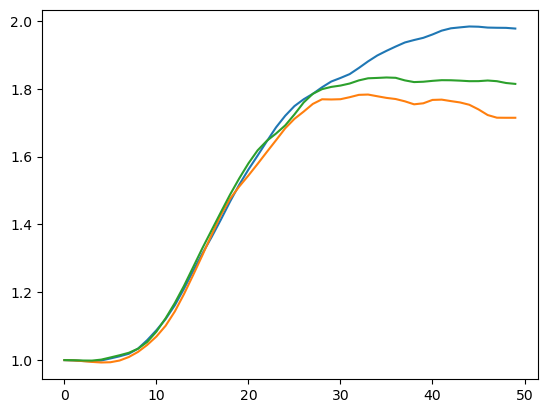

In [ ]:
for x in ordered_extension:
    plt.plot(x)

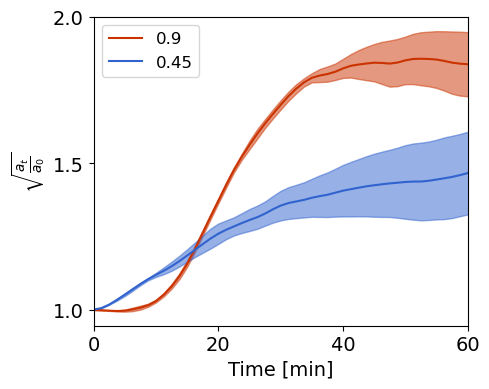

In [ ]:
fig = plt.figure(figsize=(5, 4))

plt.plot(time, ordered_extension_mean, color='#ca3300ff', label=eta2)
plt.fill_between(time, ordered_extension_mean-ordered_extension_std,
                 ordered_extension_mean+ordered_extension_std,  color='#ca3300ff', alpha=0.5)

plt.plot(time, disordered_extension_mean, color='#3163ceff', label=eta1)
plt.fill_between(time, disordered_extension_mean-disordered_extension_std,
                 disordered_extension_mean+disordered_extension_std,  color='#3163ceff', alpha=0.5)

plt.yticks([1, 1.5, 2], fontsize=14);
plt.xlim([0, 50])
plt.xticks([0, 20, 40, 60], fontsize=14)

plt.legend(fontsize=12, loc="upper left")
plt.xlabel('Time [min]',fontsize=14)
plt.ylabel(r'$\sqrt{\frac{a_t}{a_0}}$', fontsize=14)

plt.tight_layout()
#plt.savefig(f"{plot_dir}/fig_2_tissue_scale_sim_k_relax/extension_vs_time.pdf")

## alternative measure of tissue extension - use boundix box not centerlines

In [ ]:
# let's stick with the bounding box

In [ ]:
elongation_dict_bbox = {}

for key, val in tqdm(meshes_dict.items()):
    delta_series = [get_width_height(m) for m in val]
    delta_series = ndimage.gaussian_filter1d(np.stack(delta_series)/delta_series[1], axis=0, sigma=1)
    delta_series = np.log(delta_series)
    elongation = np.exp((delta_series[:,0]-delta_series[:,1])/2)
    elongation_dict_bbox[key] = elongation

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
strain = 0.2 # might bbe more pronounced yet at strain = 0.1

eta1 = 0.45 # 0.45
eta2 = 0.9 # 0.9

disordered_extension_bbox = np.stack([elongation_dict_bbox[(eta1, strain, i)] for i in [1, 2, 3]], axis=0)
disordered_extension_bbox_mean = np.mean(disordered_extension_bbox, axis=0)
disordered_extension_bbox_std = np.std(disordered_extension_bbox, axis=0)

ordered_extension_bbox = np.stack([elongation_dict_bbox[(eta2, strain, i)] for i in [1, 2, 3]], axis=0)
ordered_extension_bbox_mean = np.mean(ordered_extension_bbox, axis=0)
ordered_extension_bbox_std = np.std(ordered_extension_bbox, axis=0)

In [ ]:
ordered_extension_bbox_mean[32:36].mean(), disordered_extension_bbox_mean[32:36].mean()

(1.9520607406197412, 1.4601502448292227)

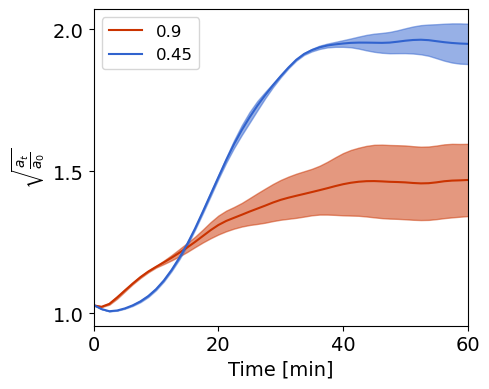

In [ ]:
fig = plt.figure(figsize=(5, 4))

plt.plot(time, disordered_extension_bbox_mean, color='#ca3300ff', label=eta2)
plt.fill_between(time, disordered_extension_bbox_mean-disordered_extension_bbox_std,
                 disordered_extension_bbox_mean+disordered_extension_bbox_std,  color='#ca3300ff', alpha=0.5)

plt.plot(time, ordered_extension_bbox_mean, color='#3163ceff', label=eta1)
plt.fill_between(time, ordered_extension_bbox_mean-ordered_extension_bbox_std,
                 ordered_extension_bbox_mean+ordered_extension_bbox_std,  color='#3163ceff', alpha=0.5)

plt.yticks([1, 1.5, 2], fontsize=14);
plt.xlim([0, 50])
plt.xticks([0, 20, 40, 60], fontsize=14)

plt.legend(fontsize=12, loc="upper left")
plt.xlabel('Time [min]',fontsize=14)
plt.ylabel(r'$\sqrt{\frac{a_t}{a_0}}$', fontsize=14)

plt.tight_layout()

plt.savefig(f"{plot_dir}/fig_2_tissue_scale_sim/elongation.pdf")


## Hexagon fraction

In [ ]:
strain = 0.2

hex_disordered = np.stack([[x[6] for x in valence_dict[(0.45, strain, i)]]
                           for i in [1, 2,]])
hex_disordered_mean = np.mean(hex_disordered, axis=0)
hex_disordered_std = np.std(hex_disordered, axis=0)

hex_ordered = np.stack([[x[6] for x in valence_dict[(0.9, strain, i)]] for i in [1, 2]]) # 0.85
hex_ordered_mean = np.mean(hex_ordered, axis=0)
hex_ordered_std = np.std(hex_ordered, axis=0)

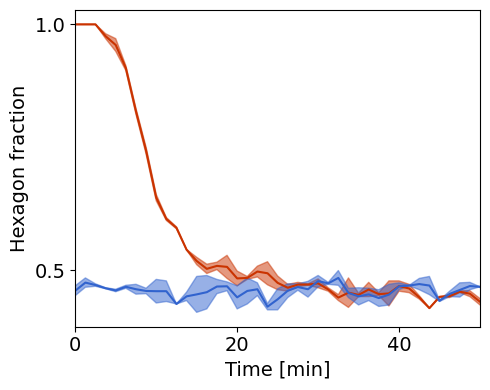

In [ ]:
fig = plt.figure(figsize=(5, 4))

plt.plot(time, hex_ordered_mean, color='#ca3300ff', label="0.85")
plt.fill_between(time, hex_ordered_mean-hex_ordered_std,
                 hex_ordered_mean+hex_ordered_std,  color='#ca3300ff', alpha=0.5)

plt.plot(time, hex_disordered_mean, color='#3163ceff', label="0.45")
plt.fill_between(time, hex_disordered_mean-hex_disordered_std,
                 hex_disordered_mean+hex_disordered_std,  color='#3163ceff', alpha=0.5)

plt.yticks([0.5, 1], fontsize=14);
plt.xlim([0, 50])
plt.xticks([0, 20, 40], fontsize=14)

#plt.legend(fontsize=12, loc="lower left")
plt.xlabel('Time [min]',fontsize=14)
plt.ylabel('Hexagon fraction', fontsize=14)

plt.tight_layout()
plt.savefig(f"{plot_dir}/fig_2_tissue_scale_sim/hexagon_fraction.pdf")

#plt.savefig(f"{plot_dir}/fig_2_tissue_scale_sim_k_relax/hexagon_fraction_vs_time.pdf")

In [ ]:
## make inset plot

keys = [4, 5, 6, 7, 8]
valence_ordered = {key: np.mean([valence_dict[(0.9, 0.25, i)][-1][key]
                                 for i in [1, 2,]]) for key in keys}
valence_disordered = {key: np.mean([valence_dict[(0.45, 0.25, i)][-1][key]
                                    for i in [1, 2,]]) for key in keys}



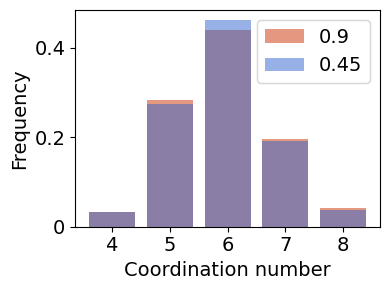

In [ ]:
fig = plt.figure(figsize=(4,3))

plt.bar(keys, [valence_ordered[x] for x in keys], alpha=.5, color="#ca3300ff", label="0.9")
plt.bar(keys, [valence_disordered[x] for x in keys], alpha=.5, color='#3163ceff', label="0.45")

plt.xlabel('Coordination number', fontsize=14)
plt.legend(fontsize=14)

plt.ylabel('Frequency', fontsize=14)
plt.xticks(keys, keys, fontsize=14)
plt.yticks([0, .2, .4], [0, .2, .4], fontsize=14)

plt.tight_layout()
plt.savefig(f"{plot_dir}/fig_2_tissue_scale_sim/coordination_number_distribution.pdf")


### anisotropy

In [ ]:
strain = 0.2

sk = 1

aniso_disordered = np.stack([anisos_dict_S[(0.45, strain, i)][:,0] for i in [1,2,3]])
aniso_disordered_mean = np.mean(aniso_disordered, axis=0)[::sk]
aniso_disordered_std = np.std(aniso_disordered, axis=0)[::sk]

aniso_ordered = np.stack([anisos_dict_S[(0.9, strain, i)][:,0] for i in [1,2, 3]])
aniso_ordered_mean = np.mean(aniso_ordered, axis=0)[::sk]
aniso_ordered_std = np.std(aniso_ordered, axis=0)[::sk]

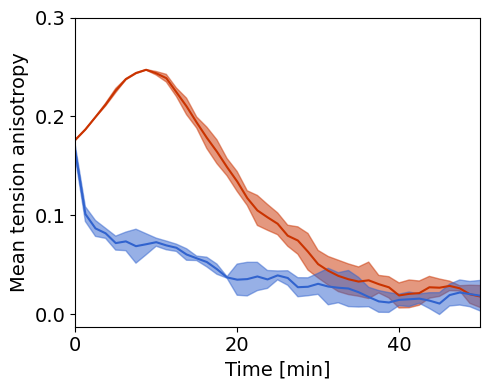

In [ ]:
fig = plt.figure(figsize=(5, 4))

plt.plot(time[::sk], aniso_ordered_mean, color='#ca3300ff', label="0.85")
plt.fill_between(time[::sk], aniso_ordered_mean-aniso_ordered_std,
                 aniso_ordered_mean+aniso_ordered_std,  color='#ca3300ff', alpha=0.5)

plt.plot(time[::sk], aniso_disordered_mean, color='#3163ceff', label="0.45")
plt.fill_between(time[::sk], aniso_disordered_mean-aniso_disordered_std,
                 aniso_disordered_mean+aniso_disordered_std,  color='#3163ceff', alpha=0.5)

plt.yticks([0., 0.1, 0.2, 0.3], fontsize=14);
plt.xlim([0, 50])
plt.xticks([0, 20, 40], fontsize=14)

#plt.legend(fontsize=12, loc="lower left")
plt.xlabel('Time [min]',fontsize=14)
plt.ylabel('Mean tension anisotropy', fontsize=14)

plt.tight_layout()


plt.savefig(f"{plot_dir}/fig_2_tissue_scale_sim/anisotropy.pdf")


#plt.savefig(f"{plot_dir}/fig_2_tissue_scale_sim_k_relax/anisotropy_vs_time.pdf")

### T1 rate

In [ ]:
strain = 0.25

scale = 1

sigma = 3

T1_disordered = np.stack([ndimage.gaussian_filter1d(T1_rate_dict[(0.45, strain, i)], sigma)
                                                    for i in [1,2,]])
T1_disordered_mean = scale*np.mean(T1_disordered, axis=0)
T1_disordered_std = scale*np.std(T1_disordered, axis=0)

T1_ordered = np.stack([ndimage.gaussian_filter1d(T1_rate_dict[(0.9, strain, i)], sigma)
                       for i in [1,2,]])
T1_ordered_mean = scale*np.mean(T1_ordered, axis=0)
T1_ordered_std = scale*np.std(T1_ordered, axis=0)

In [ ]:
T1_ordered_mean.max() / T1_ordered_mean[80]

# 2.15 for 1/8, 0.06,
# 2.25 for 1/12, 0.06
# 2 for 1/16, 0.06

# 1.75 for 1/8, 0.075
# 1.6 for 1/12, 0.075
# 1.8 for 1/16, 0.075

IndexError: index 80 is out of bounds for axis 0 with size 50

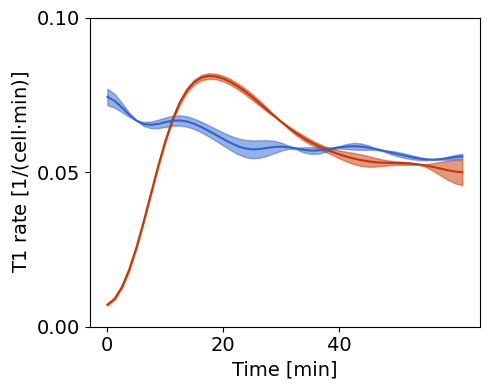

In [ ]:
fig = plt.figure(figsize=(5, 4))


plt.plot(time, T1_ordered_mean, color='#ca3300ff', label="0.9")
plt.fill_between(time, T1_ordered_mean-T1_ordered_std,
                 T1_ordered_mean+T1_ordered_std,  color='#ca3300ff', alpha=0.5)

plt.plot(time, T1_disordered_mean, color='#3163ceff', label="0.45")
plt.fill_between(time, T1_disordered_mean-T1_disordered_std,
                 T1_disordered_mean+T1_disordered_std,  color='#3163ceff', alpha=0.5)

plt.yticks([0, 0.05, 0.1], fontsize=14);
plt.ylim([0, 0.1])
plt.xticks([0, 20, 40], fontsize=14)

plt.xlabel('Time [min]',fontsize=14)
plt.ylabel(r'T1 rate [1/(cell$\cdot$min)]', fontsize=14)

plt.tight_layout()
plt.savefig(f"{plot_dir}/fig_2_tissue_scale_sim/T1_rate.pdf")

In [ ]:
40*0.05

2.0

[<matplotlib.lines.Line2D>]

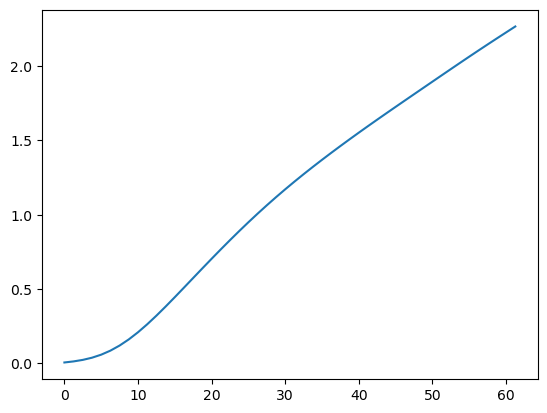

In [ ]:
plt.plot(time, np.cumsum(T1_ordered_mean)/ (time[1]-time[0]) /scale )

[<matplotlib.lines.Line2D>]

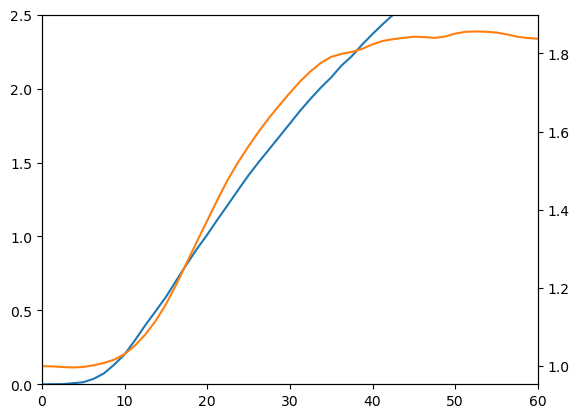

In [ ]:
plt.plot(time, np.cumsum(np.mean([T1_rate_raw_dict[(0.9, strain, i)] for i in [1, 2]], axis=0))[:505][::10])
plt.xlim([0, 60])
plt.ylim([0, 2.5])

plt.gca().twinx().plot(time, ordered_extension_mean, color='tab:orange', label="0.85")

# cummulative T1s - saturation of flow at approx 2.5 T1s/cell

### calculate shape indices

In [ ]:
strain = 0.2
eta1 = 0.45
eta2 = 0.9


In [ ]:
P_over_A_order = [np.stack([[drs.get_p_over_sqrt_A(v) for key, v in m.vertices.items() if not v.is_bdry()]
                            for m in tqdm(meshes_dict[(eta2, strain, i)])]) for i in [1, 2, 3]]
P_over_A_order = np.hstack(P_over_A_order)

P_over_A_disorder = [np.stack([[drs.get_p_over_sqrt_A(v) for key, v in m.vertices.items() if not v.is_bdry()]
                                for m in tqdm(meshes_dict[(eta1, strain, i)])]) for i in [1, 2, 3]]
P_over_A_disorder = np.hstack(P_over_A_disorder)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
mean_order = np.median(P_over_A_order, axis=1)[1:]
quartile_order_1, quartile_order_2 = (np.quantile(P_over_A_order, .25, axis=1)[1:],
                                      np.quantile(P_over_A_order, .75, axis=1)[1:])

mean_disorder = np.median(P_over_A_disorder, axis=1)[1:]
quartile_disorder_1, quartile_disorder_2 = (np.quantile(P_over_A_disorder, .25, axis=1)[1:],
                                            np.quantile(P_over_A_disorder, .75, axis=1)[1:])


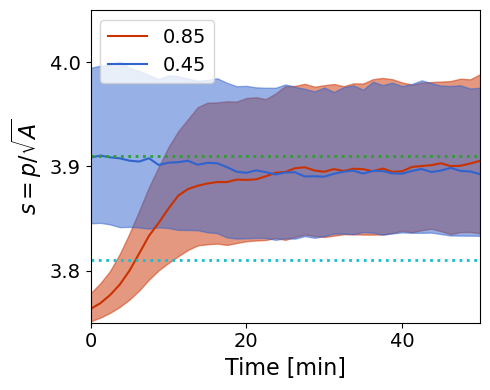

In [ ]:
fig = plt.figure(figsize=(5, 4))

plt.plot(time[:-1], mean_order, color='#ca3300ff', label="0.85")
plt.fill_between(time[:-1], quartile_order_1, quartile_order_2, color='#ca3300ff', alpha=.5)


plt.plot(time[:-1], mean_disorder, color='#3163ceff', label="0.45")
plt.fill_between(time[:-1], quartile_disorder_1, quartile_disorder_2, color='#3163ceff', alpha=.5)

#plt.xticks([0, .2/.45, 0.4/0.45], [0, 20, 40], fontsize=16)
#plt.yticks([3.7, 3.8, 3.9, 4.0, 4.1,], [3.7, 3.8, 3.9, 4.0, 4.1], fontsize=16)

plt.hlines(3.81, 0, 50, color="tab:cyan", ls="dotted", lw=2)
plt.hlines(3.91, 0, 50, color="tab:green", ls="dotted", lw=2)

plt.yticks([3.8, 3.9, 4.0], fontsize=14);
plt.ylim([3.75, 4.05])

plt.xticks([0, 20, 40], fontsize=14)
plt.xlim([0, 50])

plt.xlabel('Time [min]',fontsize=16)
plt.ylabel(r'$s=p/\sqrt{A}$', fontsize=16)
plt.legend(loc='upper left', fontsize=14)

plt.tight_layout()
plt.savefig(f"{plot_dir}/fig_2_tissue_scale_sim/shape_index_with_quartiles.pdf")

#plt.savefig(f"{plot_dir}/fig_2_tissue_scale_sim/shape_index_vs_time_with_quartiles.pdf")

### Predict remaining extension using current mean anisotropy and hex fraction

In [ ]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
traj_arr = []

for key in delta_dict_centerline.keys():
    if key[-1] == 1:
        try: 
            remaining_ext = delta_dict_centerline[key][-1]-delta_dict_centerline[key]
            remaining_ext = np.sqrt(np.exp(remaining_ext[:,0]-remaining_ext[:,1])[:-1])
            #remaining_ext = elongation_dict_bbox[key][-1]-elongation_dict_bbox[key][1:]
            traj_arr += [[anisos_dict_S[key][1:,0], [x[6] for x in valence_dict[key]][1:], remaining_ext]]
        except TypeError:
            continue
traj_arr = np.stack(traj_arr)

/tmp/ipykernel_3804605/3671208383.py:26: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12
/tmp/ipykernel_3804605/3671208383.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


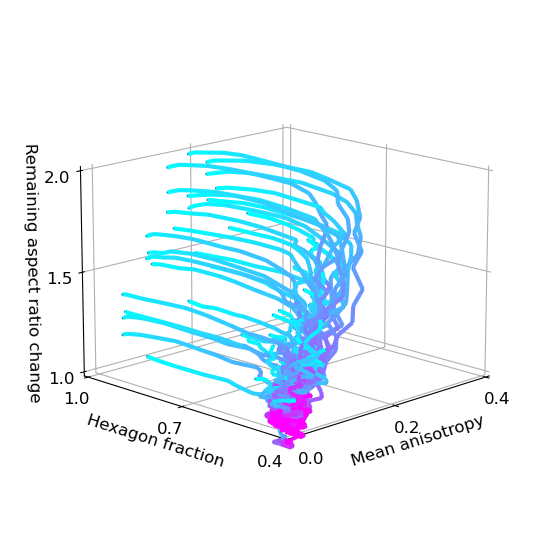

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')

for traj in traj_arr:
    ax.plot(traj[0], traj[1], traj[2], #np.log(traj[2]),
            color="tab:blue")
    colorline3d(traj[0], traj[1], traj[2], ax=ax, norm=plt.Normalize(0.0, 0.65),)

plt.xlabel("Mean anisotropy", fontsize=12)
plt.xticks([0, 0.2, 0.4], fontsize=12)
plt.ylabel("Hexagon fraction", fontsize=12)
plt.yticks([0.4, 0.7, 1], fontsize=12)

ax.set_ylim([0.4, 1.0])
ax.set_zlim([1, 2])

ax.set_zlabel(r"Remaining aspect ratio change", rotation=180, fontsize=12)
ax.set_zticks([1, 1.5, 2])
ax.tick_params(axis='z', labelsize=12)

ax.view_init(elev=15, azim=-135)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.dist = 12

plt.tight_layout()
#plt.savefig(f"{plot_dir}/trajectories_extension_hex_aniso.pdf")

#plt.savefig(f"{plot_dir}/fig_3_phase_diagram/trajectories.pdf")


plt.show()

/tmp/ipykernel_3804605/3651088291.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


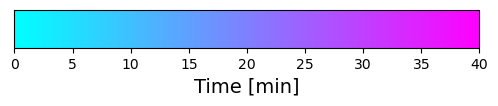

In [ ]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=0, vmax=40)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Time [min]', fontsize=14)
#plt.savefig(f"{plot_dir}/fig_3_phase_diagram/trajectories_colorbar.pdf")
plt.savefig(f"{plot_dir}/fig_3_phase_diagram/trajectories_colorbar.pdf")


fig.show()

In [ ]:
data_arr = []
keys = list(delta_dict_centerline.keys())
key_to_color = {x: ix for ix, x in enumerate(set([x[:-1] for x in keys]))}

for key in keys:
    for t in range(25): # 40
        remaining_ext = delta_dict_centerline[key][-1]-delta_dict_centerline[key][t]
        #remaining_ext = np.exp(remaining_ext[0]-remaining_ext[1])
        remaining_ext = np.sqrt(np.exp(remaining_ext[0]-remaining_ext[1]))
        data_arr += [[anisos_dict_S[key][t, 0],
                      valence_dict[(key)][t][6],
                      remaining_ext,
                      np.ones_like(remaining_ext)*key_to_color[key[:-1]]
                     ]]
data_arr = np.stack(data_arr)

In [ ]:
delta_dict_centerline[key].shape, 25*step*0.005*25

((50, 2), 31.25)

In [ ]:
len(key_to_color)

60

Text(0, 0.5, 'Remaining extension')

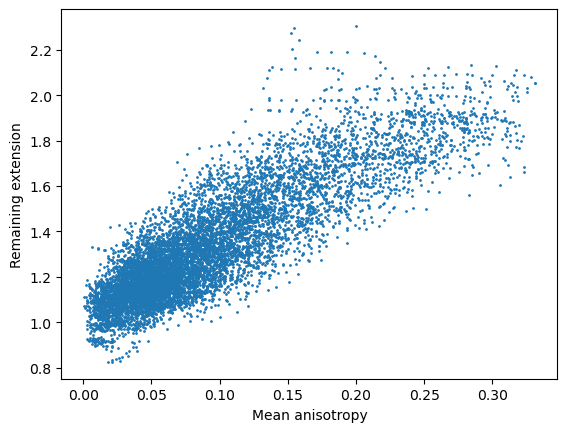

In [ ]:
fig = plt.figure()
plt.scatter(data_arr[:,0], data_arr[:,2], s=1)
plt.xlabel("Mean anisotropy")
plt.ylabel("Remaining extension")


In [ ]:
## using linear model - how good?

reg = linear_model.LinearRegression().fit(data_arr[:,:2], data_arr[:,2])

In [ ]:
data_arr_tf = np.stack([#np.ones_like(data_arr[:,0]),
                        (data_arr[:,0]-data_arr[:,0].mean())/data_arr[:,0].std(),
                        (data_arr[:,1]-data_arr[:,1].mean())/data_arr[:,1].std(),
                        #(data_arr[:,1]>0.9) * data_arr[:,0],
                        #data_arr[:,1] * data_arr[:,0]
                       ], axis=-1) 

ground_truth = (data_arr[:,2]-data_arr[:,2].mean())/data_arr[:,2].std()

# 6.3% error using hex and aniso, 6.6% using aniso only, 10% using hex only

In [ ]:
reg = linear_model.LinearRegression().fit(data_arr_tf, ground_truth)
np.mean(np.abs(reg.predict(data_arr_tf)-ground_truth)) / np.mean(np.abs(ground_truth))


0.4541361498089137

In [ ]:
reg.coef_

array([0.76982121, 0.18698891])

(array([1376., 2649., 1837., 1132.,  689.,  498.,  318.,  279.,  159.,
          63.]),
 array([0.0005856 , 0.03363817, 0.06669074, 0.09974332, 0.13279589,
        0.16584847, 0.19890104, 0.23195361, 0.26500619, 0.29805876,
        0.33111134]),
 <BarContainer object of 10 artists>)

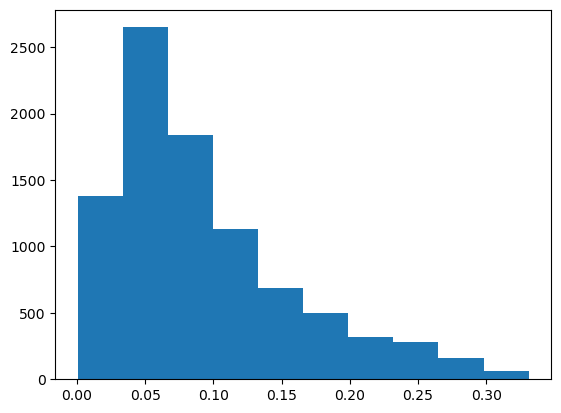

In [ ]:
plt.hist(data_arr[:,0])

(array([ 471., 5087., 1470.,  471.,  240.,  157.,  147.,  170.,  181.,
         606.]),
 array([0.375 , 0.4375, 0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125,
        0.875 , 0.9375, 1.    ]),
 <BarContainer object of 10 artists>)

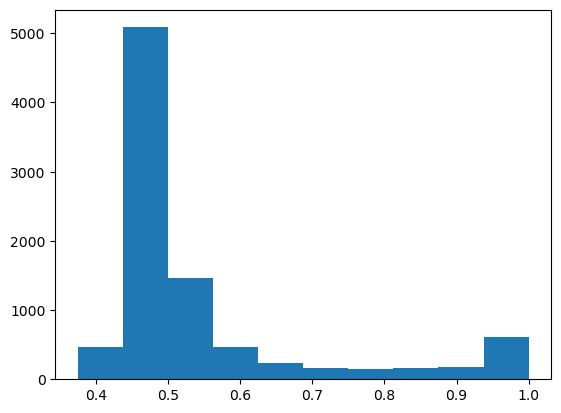

In [ ]:
plt.hist(data_arr[:,1])

In [ ]:
%matplotlib inline

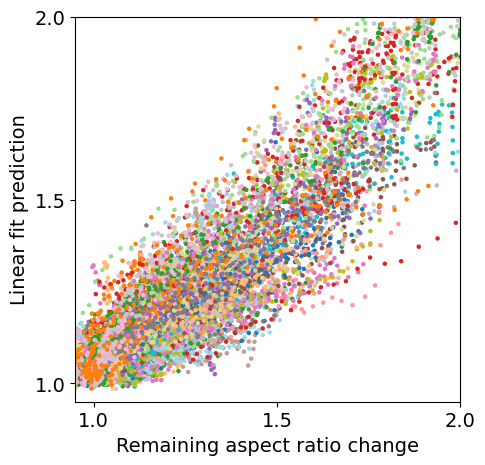

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.scatter(data_arr[:,2], reg.predict(data_arr[:,:2]), s=5, c=data_arr[:,-1], cmap="tab20")
plt.xlim([0.95, 2])
plt.ylim([0.95, 2])

plt.xticks([1, 1.5, 2,], fontsize=14)
plt.yticks([1, 1.5, 2], fontsize=14)

plt.ylabel("Linear fit prediction", fontsize=14)
plt.xlabel("Remaining aspect ratio change", fontsize=14)
plt.gca().set_aspect('equal', adjustable='box')


#plt.savefig(f"{plot_dir}/fig_3_phase_diagram/predicted_vs_actual_extension.pdf")

#plt.savefig(f"{plot_dir}/fig_3_phase_diagram/predicted_vs_actual_extension.pdf")

In [ ]:
## Now using excess anisotropy - for my own amusement

array([0.35790426, 0.04550427, 0.35499975])

In [ ]:
traj_arr = []

for key in delta_dict_centerline.keys():
    if key[-1] == 1:
        try: 
            remaining_ext = delta_dict_centerline[key][-1]-delta_dict_centerline[key]
            remaining_ext = np.sqrt(np.exp(remaining_ext[:,0]-remaining_ext[:,1])[:-1])
            traj_arr += [[excesss_anisos_S[key][:,1],
                          excesss_anisos_S[key][:, 2],
                          #[x[6] for x in valence_dict[key]],
                          remaining_ext]]
        except TypeError:
            continue
traj_arr = np.stack(traj_arr)

/tmp/ipykernel_3804605/420144505.py:28: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12
/tmp/ipykernel_3804605/420144505.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


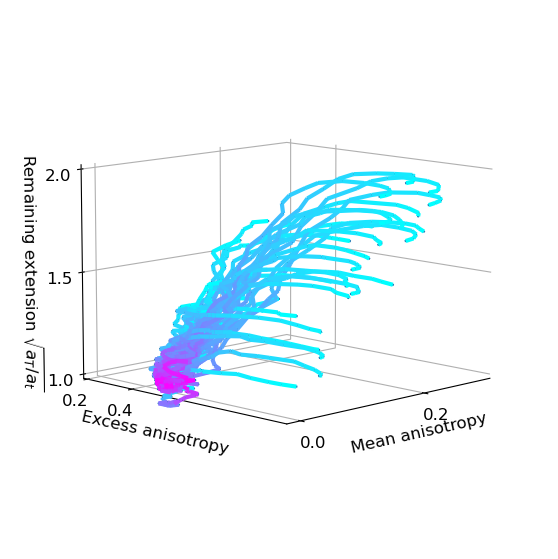

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')

for traj in traj_arr:
    ax.plot(traj[0], traj[1], traj[2], color="tab:blue")
    colorline3d(traj[0], traj[1], traj[2], ax=ax, )

plt.xlabel("Mean anisotropy", fontsize=12)
plt.xticks([0, 0.2,], fontsize=12)
plt.ylabel("Excess anisotropy", fontsize=12)
plt.yticks([0.2, 0.4], fontsize=12)
ax.invert_yaxis()

#ax.set_ylim([0.4, 1.0])
ax.set_zlim([1, 2])

ax.set_zlabel(r"Remaining extension $\sqrt{a_T/a_t}$", rotation=180, fontsize=12)
ax.set_zticks([1, 1.5, 2])
ax.tick_params(axis='z', labelsize=12)


ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.view_init(elev=10, azim=-135)

ax.dist = 12

plt.tight_layout()
#plt.savefig(f"{plot_dir}/trajectories_extension_hex_aniso.pdf")

plt.show()

### make a heatmap

In [ ]:
initial_strains = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30][:-1]#[::2]
etas = [0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]

heatmap = np.zeros((len(etas), len(initial_strains)))

for ix, eta in enumerate(etas):
    for iy, strain in enumerate(initial_strains):
        try:
            #final = np.mean([delta_dict_centerline[(eta, strain, i)][45:50,:].mean(axis=0)
            #                 for i in [1, 2, 3]], axis=0)
            #final = np.exp((final[0]-final[1])/2)
            final = np.mean([elongation_dict_bbox[(eta, strain, i)][36:40].mean(axis=0) # [:45].max()
                            for i in [1, 2, 3]], axis=0) 
            heatmap[ix, iy] = final
        
        except KeyError:
            heatmap[ix, iy] = np.nan


In [ ]:
delta_dict_centerline[(eta, strain, 1)].shape

(50, 2)

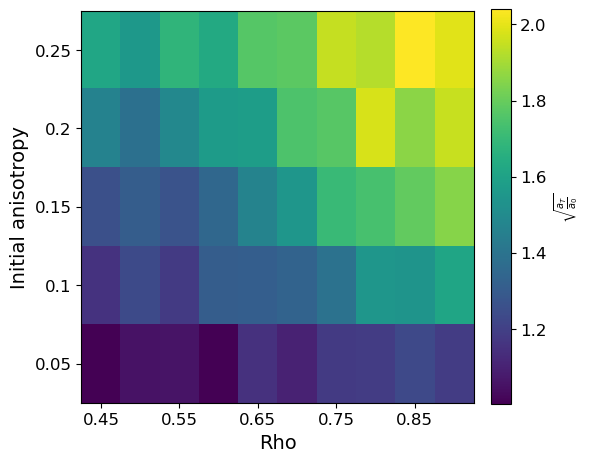

In [ ]:
fig = plt.figure(figsize=(6, 6))

plt.imshow(heatmap.T[::-1,:], aspect=heatmap.shape[0]/heatmap.shape[1])

plt.xticks(np.arange(len(etas))[::2], etas[::2], fontsize=12)
plt.xlabel("Rho", fontsize=14)

plt.yticks(np.arange(len(initial_strains)), initial_strains[::-1], fontsize=12)
plt.ylabel("Initial anisotropy", fontsize=14)

cbar = plt.colorbar(label=r"$\sqrt{\frac{a_T}{a_0}}$", fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
#plt.savefig(f"{plot_dir}/fig_3_phase_diagram/extension_heatmap.pdf")


# maybe I need more realizatons to make the curve smoother ....

plt.savefig(f"{plot_dir}/fig_3_phase_diagram/phase_diagram_heatmap.pdf")


In [ ]:
## plot hexagon fraction vs rho


In [ ]:
hex_frac = np.stack([np.stack([valence_dict[(eta, 0.05, i)][0][6] for i in [1, 2, 3]]) for eta in etas])
hex_frac_mean = hex_frac.mean(axis=1)
hex_frac_std = hex_frac.std(axis=1)

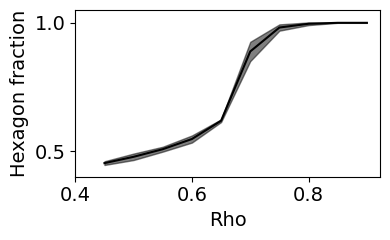

In [ ]:
fig = plt.figure(figsize=(4, 2.5))


plt.plot(etas, hex_frac_mean, color='k', label="0.85")
plt.fill_between(etas, hex_frac_mean-hex_frac_std,
                 hex_frac_mean+hex_frac_std,  color='k', alpha=0.5)

plt.yticks([0.5, 1], fontsize=14);
plt.ylim([0.4, 1.05])
plt.xticks([0.4, 0.6, 0.8], fontsize=14)

plt.xlabel('Rho',fontsize=14)
plt.ylabel('Hexagon fraction', fontsize=14)

plt.tight_layout()
plt.savefig(f"{plot_dir}/fig_3_phase_diagram/hex_fraction_vs_rho.pdf")

#plt.savefig(f"{plot_dir}/fig_3_phase_diagram/hex_fraction_vs_rho.pdf")

### T1 timing

In [ ]:
# compute relative tensions
tension_dicts = [x.get_rel_tension() for x in meshes]

In [ ]:
# isolate and align T1s

t_ref = 100
dt = 45

tensions_stacked = []
for i in range(t_ref, t_ref+dt):
    for e in last_flipped_edges[i]:
        if not e in property_dict['passive_edges']:
            tensions = np.stack([x[e] for x in tension_dicts])
            tensions_stacked.append(tensions[i-t_ref:i-1]) # :i+t_ref
            
tensions_stacked = np.stack(tensions_stacked)


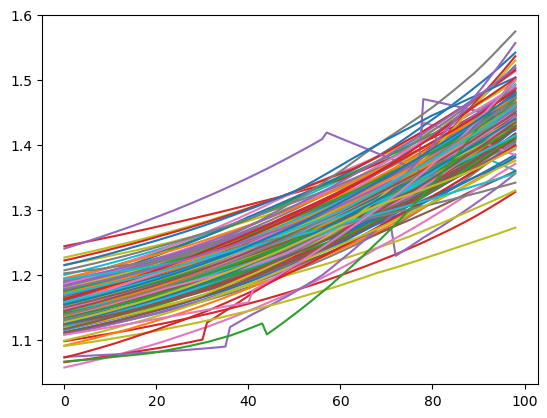

In [ ]:
for x in tensions_stacked:
    plt.plot(x)

In [ ]:
mean = tensions_stacked.mean(axis=0)

dt = 0.005
time = np.arange(mean.shape[0])


In [ ]:
mean.min(), mean.max() # corresponds to times -14 and -1.5 min in embryo time series. (14-1.5) / time.max()

(1.1521689798730228, 1.4455442308800737)

[<matplotlib.lines.Line2D>]

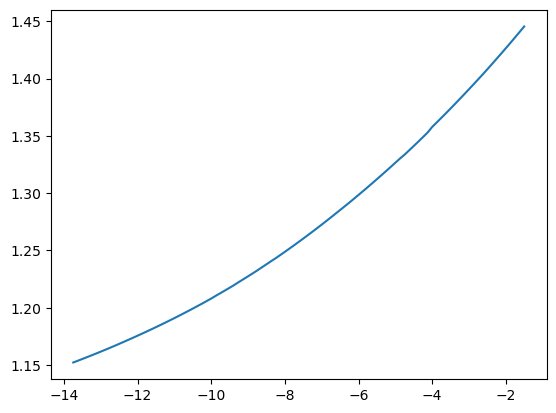

In [ ]:
plt.plot(-25 * dt * time[::-1]-1.5, mean)

In [ ]:
300 * dt * 25 # good!

37.5